# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

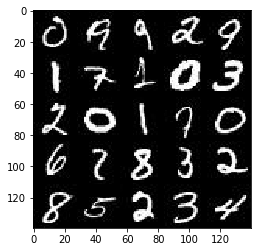

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

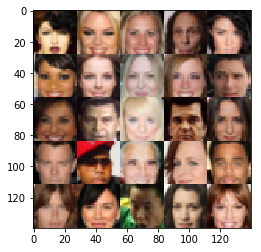

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # Arbitrarily defining an alpha parameter for Leaky ReLU
    alpha = 0.15
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x?
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x512
        
        x4 = tf.layers.conv2d(relu3, 1024, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 2x2x1024

        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*1024))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Arbitrarily defining an alpha parameter for Leaky ReLU
    alpha = 0.15
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        fc = tf.layers.dense(z, 2*2*1024)
        
        # Reshape it to start the convolutional stack
        x0 = tf.reshape(fc, (-1, 2, 2, 1024))
        x0 = tf.layers.batch_normalization(x0, training=is_train)
        x0 = tf.maximum(alpha * x0, x0)
        # 2x2x1024 now
        
        x1 = tf.layers.conv2d_transpose(x0, 512, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x? now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Setting our image dimensions as separate variables
    image_width = data_shape[1]
    image_height = data_shape[2]
    
    # Setting image depth (channels)
    image_channels = 1
    if (data_image_mode == 'L'):
        image_channels = 1
    elif (data_image_mode == 'RGB'):
        image_channels = 3
    
    # Create input placeholders
    input_real, input_z, lr = model_inputs(image_width,
                                           image_height,
                                           image_channels,
                                           z_dim)

    # Create loss functions for both generator and discriminator
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Create optimizers for both generator and discriminator
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    # iteration counter
    steps = 0
    # how many steps need to print errors
    print_every = 10
    # how many steps needed to show generated images
    show_every = 100
    # how many generated images should be shown
    show_n_images = 36
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                steps+=1
                # normalizing input images to (-1,1), as they are originally in (-0.5,0.5) format
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,
                                                     input_z: batch_z,
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z,
                                                     input_real: batch_images,
                                                     lr: learning_rate})

                # print errors every "print_every" steps
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                # show sample generated images every "show_every" steps
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
    
        # show enging sample images
        show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
    
    # print ending message
    print("model trained")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 1.2503
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 3.0284
Epoch 1/2... Discriminator Loss: 0.5826... Generator Loss: 1.6225
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 2.2583
Epoch 1/2... Discriminator Loss: 1.2571... Generator Loss: 0.5172
Epoch 1/2... Discriminator Loss: 0.3534... Generator Loss: 4.1592
Epoch 1/2... Discriminator Loss: 0.4055... Generator Loss: 2.6542
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 3.1779
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 5.6648
Epoch 1/2... Discriminator Loss: 2.9237... Generator Loss: 7.3057


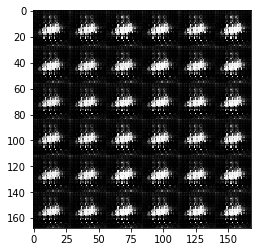

Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 8.9917
Epoch 1/2... Discriminator Loss: 0.5595... Generator Loss: 5.9296
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 5.0520
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.2003
Epoch 1/2... Discriminator Loss: 0.4379... Generator Loss: 3.0335
Epoch 1/2... Discriminator Loss: 0.5030... Generator Loss: 2.8917
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 0.4227... Generator Loss: 2.7924
Epoch 1/2... Discriminator Loss: 1.5892... Generator Loss: 0.4424
Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 3.0217


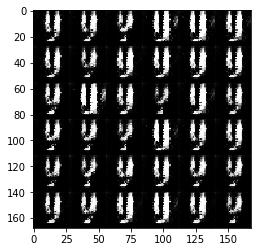

Epoch 1/2... Discriminator Loss: 0.5345... Generator Loss: 2.9014
Epoch 1/2... Discriminator Loss: 0.4649... Generator Loss: 3.1548
Epoch 1/2... Discriminator Loss: 0.9797... Generator Loss: 1.1243
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 1.5889
Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 0.4616... Generator Loss: 2.3048
Epoch 1/2... Discriminator Loss: 0.5166... Generator Loss: 5.2561
Epoch 1/2... Discriminator Loss: 0.8638... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.3746... Generator Loss: 0.4542
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.6623


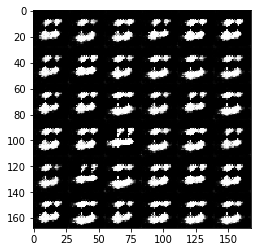

Epoch 1/2... Discriminator Loss: 0.4380... Generator Loss: 2.4127
Epoch 1/2... Discriminator Loss: 0.4850... Generator Loss: 2.2514
Epoch 1/2... Discriminator Loss: 1.1990... Generator Loss: 2.1891
Epoch 1/2... Discriminator Loss: 0.4522... Generator Loss: 3.0606
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 4.4599
Epoch 1/2... Discriminator Loss: 0.4544... Generator Loss: 3.0271
Epoch 1/2... Discriminator Loss: 0.4970... Generator Loss: 2.2251
Epoch 1/2... Discriminator Loss: 1.0913... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 0.6926... Generator Loss: 1.4275
Epoch 1/2... Discriminator Loss: 0.6846... Generator Loss: 4.3167


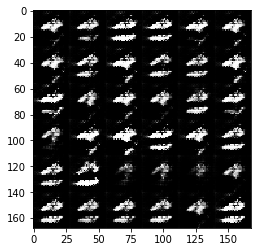

Epoch 1/2... Discriminator Loss: 0.5141... Generator Loss: 2.2271
Epoch 1/2... Discriminator Loss: 1.4700... Generator Loss: 5.9827
Epoch 1/2... Discriminator Loss: 0.4453... Generator Loss: 2.8263
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 2.3424
Epoch 1/2... Discriminator Loss: 0.6328... Generator Loss: 2.7173
Epoch 1/2... Discriminator Loss: 0.4197... Generator Loss: 4.0449
Epoch 1/2... Discriminator Loss: 0.5578... Generator Loss: 2.1200
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 2.0982
Epoch 1/2... Discriminator Loss: 1.4420... Generator Loss: 4.9493
Epoch 1/2... Discriminator Loss: 0.5726... Generator Loss: 3.4444


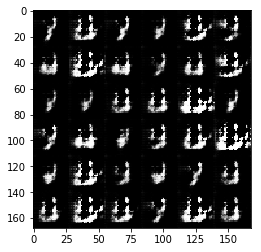

Epoch 1/2... Discriminator Loss: 0.7735... Generator Loss: 3.0059
Epoch 1/2... Discriminator Loss: 0.5010... Generator Loss: 2.9251
Epoch 1/2... Discriminator Loss: 0.4298... Generator Loss: 4.8088
Epoch 1/2... Discriminator Loss: 0.7430... Generator Loss: 6.0371
Epoch 1/2... Discriminator Loss: 0.5062... Generator Loss: 3.7926
Epoch 1/2... Discriminator Loss: 0.4575... Generator Loss: 2.7664
Epoch 1/2... Discriminator Loss: 0.9025... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 9.6113
Epoch 1/2... Discriminator Loss: 0.6842... Generator Loss: 2.0466
Epoch 1/2... Discriminator Loss: 0.4783... Generator Loss: 2.9243


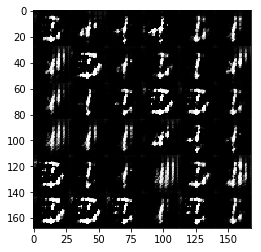

Epoch 1/2... Discriminator Loss: 0.4419... Generator Loss: 2.5614
Epoch 1/2... Discriminator Loss: 0.4100... Generator Loss: 3.7870
Epoch 1/2... Discriminator Loss: 1.5234... Generator Loss: 5.9046
Epoch 1/2... Discriminator Loss: 0.4221... Generator Loss: 4.1226
Epoch 1/2... Discriminator Loss: 2.1749... Generator Loss: 9.8260
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 1.7798
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 4.0964
Epoch 1/2... Discriminator Loss: 0.5359... Generator Loss: 3.1032
Epoch 1/2... Discriminator Loss: 0.4948... Generator Loss: 6.8685
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 1.6796


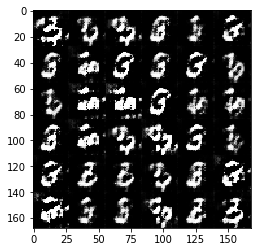

Epoch 1/2... Discriminator Loss: 0.6240... Generator Loss: 1.6158
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 2.9275
Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 6.5391
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.7703
Epoch 1/2... Discriminator Loss: 0.9955... Generator Loss: 1.0526
Epoch 1/2... Discriminator Loss: 0.4468... Generator Loss: 3.6847
Epoch 1/2... Discriminator Loss: 0.7392... Generator Loss: 1.5169
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 3.4619
Epoch 1/2... Discriminator Loss: 0.5012... Generator Loss: 2.9452
Epoch 1/2... Discriminator Loss: 0.8751... Generator Loss: 1.0660


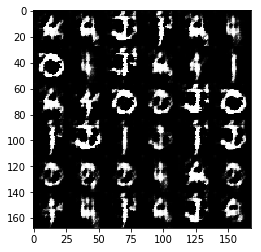

Epoch 1/2... Discriminator Loss: 0.7847... Generator Loss: 5.1297
Epoch 1/2... Discriminator Loss: 0.5884... Generator Loss: 1.8023
Epoch 1/2... Discriminator Loss: 0.6083... Generator Loss: 2.8503
Epoch 1/2... Discriminator Loss: 0.8200... Generator Loss: 3.2181
Epoch 1/2... Discriminator Loss: 0.4057... Generator Loss: 3.8053
Epoch 1/2... Discriminator Loss: 0.4122... Generator Loss: 3.5503
Epoch 1/2... Discriminator Loss: 0.7003... Generator Loss: 1.6661
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.6216
Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.4771
Epoch 1/2... Discriminator Loss: 0.6122... Generator Loss: 1.7097


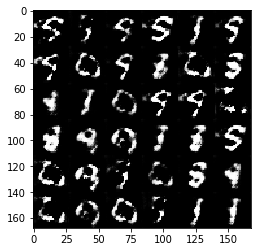

Epoch 1/2... Discriminator Loss: 0.7438... Generator Loss: 1.3690
Epoch 1/2... Discriminator Loss: 0.6356... Generator Loss: 1.5306
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 0.7494... Generator Loss: 1.5240
Epoch 2/2... Discriminator Loss: 0.6501... Generator Loss: 4.5741
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 1.3492
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 1.4106
Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 1.4710
Epoch 2/2... Discriminator Loss: 0.5048... Generator Loss: 3.1830
Epoch 2/2... Discriminator Loss: 0.5246... Generator Loss: 3.1202


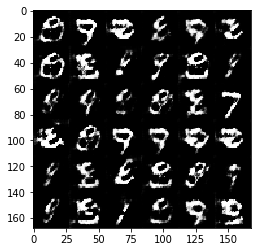

Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 2.3200
Epoch 2/2... Discriminator Loss: 0.9219... Generator Loss: 1.9420
Epoch 2/2... Discriminator Loss: 2.3933... Generator Loss: 0.1862
Epoch 2/2... Discriminator Loss: 0.8454... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 0.7718... Generator Loss: 1.2267
Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 3.6515
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 1.1894
Epoch 2/2... Discriminator Loss: 0.6574... Generator Loss: 1.4871
Epoch 2/2... Discriminator Loss: 0.8692... Generator Loss: 4.3211
Epoch 2/2... Discriminator Loss: 0.5142... Generator Loss: 3.3253


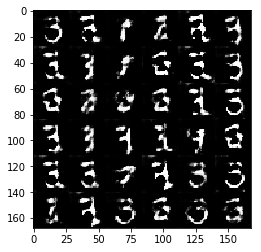

Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 1.4346
Epoch 2/2... Discriminator Loss: 0.7373... Generator Loss: 1.5212
Epoch 2/2... Discriminator Loss: 0.7655... Generator Loss: 2.0649
Epoch 2/2... Discriminator Loss: 0.4514... Generator Loss: 3.0754
Epoch 2/2... Discriminator Loss: 0.3828... Generator Loss: 3.5984
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 3.6648
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.2943
Epoch 2/2... Discriminator Loss: 0.4027... Generator Loss: 4.3585
Epoch 2/2... Discriminator Loss: 0.5907... Generator Loss: 1.6492
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.9021


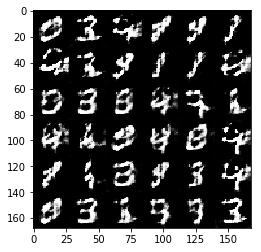

Epoch 2/2... Discriminator Loss: 0.8426... Generator Loss: 1.0914
Epoch 2/2... Discriminator Loss: 0.7943... Generator Loss: 1.7900
Epoch 2/2... Discriminator Loss: 0.6881... Generator Loss: 1.3524
Epoch 2/2... Discriminator Loss: 0.7282... Generator Loss: 4.7523
Epoch 2/2... Discriminator Loss: 0.5292... Generator Loss: 2.4279
Epoch 2/2... Discriminator Loss: 1.0620... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 0.7218... Generator Loss: 1.5800
Epoch 2/2... Discriminator Loss: 0.5664... Generator Loss: 2.0278
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 2.7521
Epoch 2/2... Discriminator Loss: 0.5097... Generator Loss: 2.3062


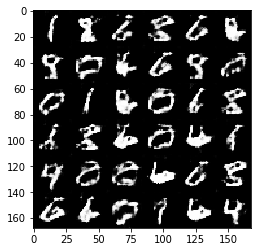

Epoch 2/2... Discriminator Loss: 2.4998... Generator Loss: 0.1772
Epoch 2/2... Discriminator Loss: 1.3562... Generator Loss: 0.7233
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.9722
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 2.2796
Epoch 2/2... Discriminator Loss: 0.7079... Generator Loss: 1.5876
Epoch 2/2... Discriminator Loss: 1.0868... Generator Loss: 4.7621
Epoch 2/2... Discriminator Loss: 0.5406... Generator Loss: 2.0388
Epoch 2/2... Discriminator Loss: 0.5766... Generator Loss: 1.8478
Epoch 2/2... Discriminator Loss: 0.9173... Generator Loss: 0.9046
Epoch 2/2... Discriminator Loss: 2.1179... Generator Loss: 5.9350


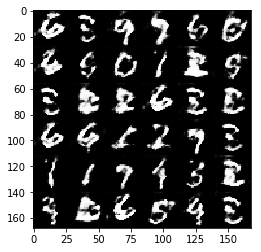

Epoch 2/2... Discriminator Loss: 0.9096... Generator Loss: 1.0312
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.2398
Epoch 2/2... Discriminator Loss: 1.6173... Generator Loss: 0.4081
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.6659
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 1.8166
Epoch 2/2... Discriminator Loss: 0.6716... Generator Loss: 2.5950
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.5091
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.2737
Epoch 2/2... Discriminator Loss: 0.6683... Generator Loss: 1.4764
Epoch 2/2... Discriminator Loss: 0.7307... Generator Loss: 1.2576


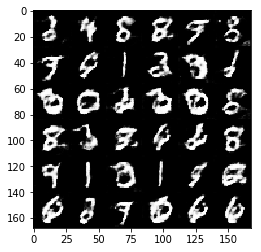

Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.7341
Epoch 2/2... Discriminator Loss: 0.6836... Generator Loss: 2.2939
Epoch 2/2... Discriminator Loss: 1.5211... Generator Loss: 0.4799
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 2.8405
Epoch 2/2... Discriminator Loss: 1.0191... Generator Loss: 1.0022
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 1.6517
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.7997
Epoch 2/2... Discriminator Loss: 1.0082... Generator Loss: 3.0657
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 3.8795
Epoch 2/2... Discriminator Loss: 0.7280... Generator Loss: 1.7176


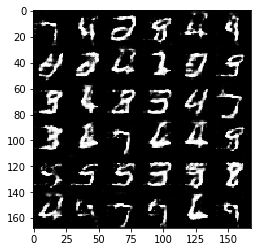

Epoch 2/2... Discriminator Loss: 1.1293... Generator Loss: 0.7725
Epoch 2/2... Discriminator Loss: 0.6218... Generator Loss: 2.1182
Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.7431
Epoch 2/2... Discriminator Loss: 0.8488... Generator Loss: 1.3151
Epoch 2/2... Discriminator Loss: 0.7183... Generator Loss: 1.4078
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.6706
Epoch 2/2... Discriminator Loss: 0.7293... Generator Loss: 3.1741
Epoch 2/2... Discriminator Loss: 0.7361... Generator Loss: 1.4879
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.7128
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 1.8570


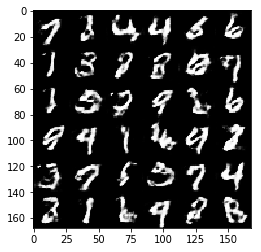

Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 2.0408
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.0855
Epoch 2/2... Discriminator Loss: 0.8850... Generator Loss: 1.0958
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.1621
Epoch 2/2... Discriminator Loss: 0.8004... Generator Loss: 1.2195
Epoch 2/2... Discriminator Loss: 1.3788... Generator Loss: 4.3760
Epoch 2/2... Discriminator Loss: 0.7368... Generator Loss: 3.4669
Epoch 2/2... Discriminator Loss: 0.5031... Generator Loss: 2.1020
Epoch 2/2... Discriminator Loss: 0.7513... Generator Loss: 1.2617
Epoch 2/2... Discriminator Loss: 0.5141... Generator Loss: 2.1920


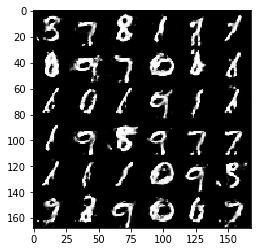

Epoch 2/2... Discriminator Loss: 1.5380... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.5395
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.9336
Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 3.6628
Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.6570
Epoch 2/2... Discriminator Loss: 0.5773... Generator Loss: 1.8944
Epoch 2/2... Discriminator Loss: 0.5498... Generator Loss: 2.2583


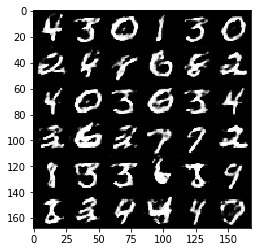

model trained


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 5.2059
Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 2.1603
Epoch 1/1... Discriminator Loss: 0.5558... Generator Loss: 5.0458
Epoch 1/1... Discriminator Loss: 3.0224... Generator Loss: 8.6670
Epoch 1/1... Discriminator Loss: 0.3731... Generator Loss: 7.3602
Epoch 1/1... Discriminator Loss: 2.5651... Generator Loss: 1.8222
Epoch 1/1... Discriminator Loss: 1.8993... Generator Loss: 4.2527
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 2.3232
Epoch 1/1... Discriminator Loss: 0.9440... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 3.0247... Generator Loss: 0.0753


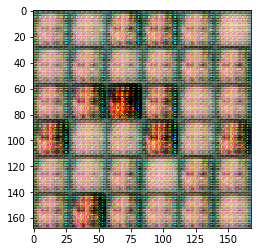

Epoch 1/1... Discriminator Loss: 0.5413... Generator Loss: 2.7333
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 0.5306... Generator Loss: 1.8178
Epoch 1/1... Discriminator Loss: 1.0883... Generator Loss: 1.0794
Epoch 1/1... Discriminator Loss: 0.6463... Generator Loss: 2.0626
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 3.2934
Epoch 1/1... Discriminator Loss: 2.3284... Generator Loss: 9.2700
Epoch 1/1... Discriminator Loss: 0.7508... Generator Loss: 6.5186
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 3.9226
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.7929


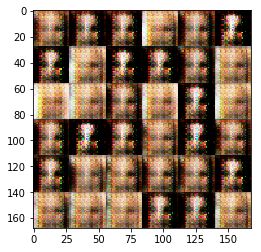

Epoch 1/1... Discriminator Loss: 0.8539... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 2.4392
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 2.1464... Generator Loss: 2.8540
Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.6931
Epoch 1/1... Discriminator Loss: 1.1305... Generator Loss: 1.8808
Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.7157
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.9744
Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 1.3188


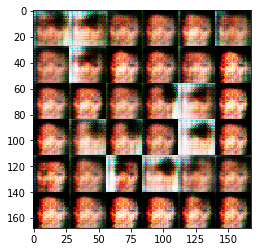

Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.9993
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.9528
Epoch 1/1... Discriminator Loss: 0.5538... Generator Loss: 1.9411
Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 1.9736
Epoch 1/1... Discriminator Loss: 1.3425... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.8441... Generator Loss: 3.7781
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.5253
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5818


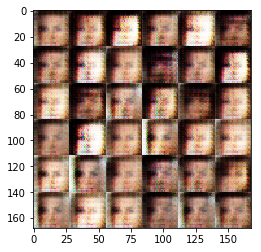

Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.7880
Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 1.8969
Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.7671... Generator Loss: 3.7856
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.6573
Epoch 1/1... Discriminator Loss: 0.6921... Generator Loss: 1.7548
Epoch 1/1... Discriminator Loss: 3.4925... Generator Loss: 7.0050
Epoch 1/1... Discriminator Loss: 0.9823... Generator Loss: 1.4537
Epoch 1/1... Discriminator Loss: 0.7583... Generator Loss: 1.5787
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 2.2431


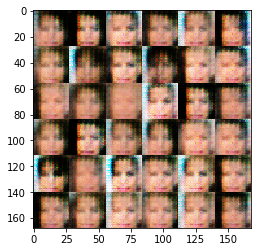

Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.6813
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 2.1470
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.2830
Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 0.8414... Generator Loss: 1.4109
Epoch 1/1... Discriminator Loss: 1.7082... Generator Loss: 2.4823
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.2433


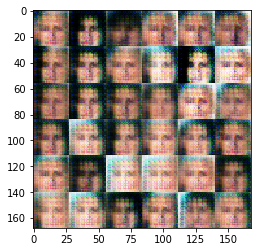

Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.9567
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 2.0869
Epoch 1/1... Discriminator Loss: 1.6491... Generator Loss: 0.5376
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.9948
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.0475
Epoch 1/1... Discriminator Loss: 0.8125... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6328


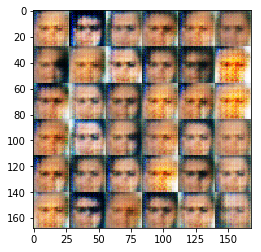

Epoch 1/1... Discriminator Loss: 0.9943... Generator Loss: 2.1889
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 0.6587... Generator Loss: 1.9339
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.4498
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 4.2747
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.1865
Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.0672
Epoch 1/1... Discriminator Loss: 0.7140... Generator Loss: 1.4849


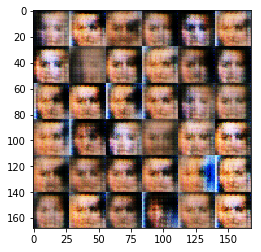

Epoch 1/1... Discriminator Loss: 0.6749... Generator Loss: 1.9582
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.2426... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.1367
Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.4121
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.9189
Epoch 1/1... Discriminator Loss: 0.7373... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.2960
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.9524


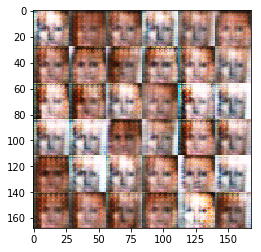

Epoch 1/1... Discriminator Loss: 2.1117... Generator Loss: 0.2502
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.1863
Epoch 1/1... Discriminator Loss: 0.6361... Generator Loss: 1.5871
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.3371
Epoch 1/1... Discriminator Loss: 1.0000... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 2.5708
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.5778
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 1.0013
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 1.4705


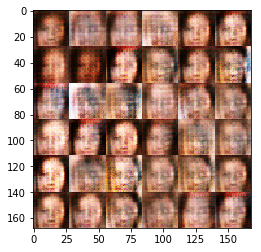

Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.3760
Epoch 1/1... Discriminator Loss: 1.0095... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.0409... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 1.8680
Epoch 1/1... Discriminator Loss: 0.7643... Generator Loss: 2.0634
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.4048
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.2427
Epoch 1/1... Discriminator Loss: 0.6616... Generator Loss: 3.0260
Epoch 1/1... Discriminator Loss: 0.6502... Generator Loss: 4.3450


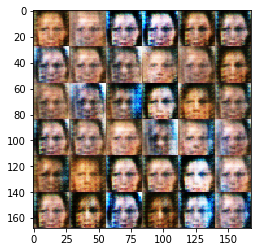

Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.9024
Epoch 1/1... Discriminator Loss: 1.5752... Generator Loss: 3.4459
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.0117... Generator Loss: 3.8776
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 0.8779
Epoch 1/1... Discriminator Loss: 0.8039... Generator Loss: 2.8221
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 2.1454... Generator Loss: 5.0683


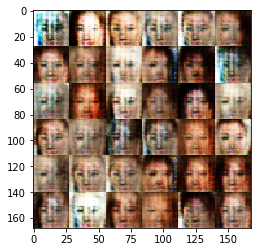

Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 3.8256
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.2044
Epoch 1/1... Discriminator Loss: 0.8502... Generator Loss: 2.5875
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.4442
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.3190
Epoch 1/1... Discriminator Loss: 2.7823... Generator Loss: 6.2423
Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 2.0050
Epoch 1/1... Discriminator Loss: 0.8732... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 0.6647... Generator Loss: 1.7539


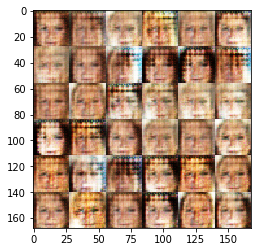

Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 0.9415... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.1229... Generator Loss: 1.1613


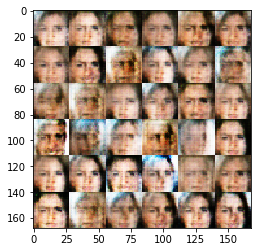

Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.8542
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.2236
Epoch 1/1... Discriminator Loss: 1.8249... Generator Loss: 4.4722
Epoch 1/1... Discriminator Loss: 0.5120... Generator Loss: 3.6957
Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.0739
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 1.8389
Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.7281


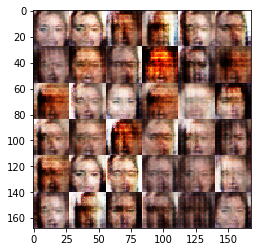

Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8131
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 2.6972
Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.5436
Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.0361
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 0.5883... Generator Loss: 1.6080
Epoch 1/1... Discriminator Loss: 0.9084... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.5022... Generator Loss: 0.4814
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.3350


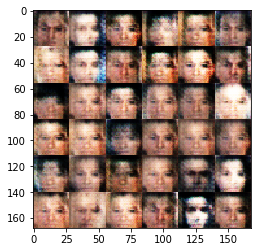

Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 2.0097
Epoch 1/1... Discriminator Loss: 0.7485... Generator Loss: 3.8163
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 4.8109
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.0572
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.4753
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 4.1661
Epoch 1/1... Discriminator Loss: 0.8034... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 2.1714
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 4.6738
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.2641


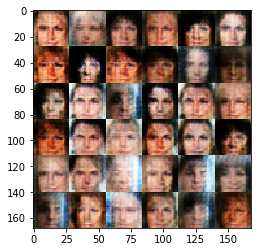

Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 0.7663... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.4801
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 2.8325
Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 3.0159
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.4844
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 1.7817
Epoch 1/1... Discriminator Loss: 0.8588... Generator Loss: 1.4292


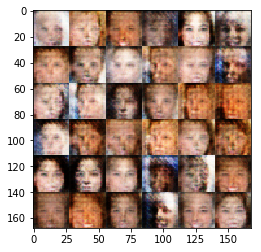

Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 5.0314
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.3954
Epoch 1/1... Discriminator Loss: 0.7101... Generator Loss: 1.4635
Epoch 1/1... Discriminator Loss: 0.6977... Generator Loss: 1.5779
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.6672
Epoch 1/1... Discriminator Loss: 1.2333... Generator Loss: 4.1787
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.3166
Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 2.0380
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 3.7643
Epoch 1/1... Discriminator Loss: 0.7499... Generator Loss: 1.2277


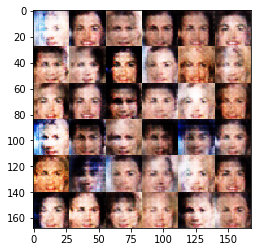

Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 2.0789
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 1.2227
Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.7617
Epoch 1/1... Discriminator Loss: 0.7929... Generator Loss: 1.6288
Epoch 1/1... Discriminator Loss: 0.6433... Generator Loss: 1.5532
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 2.4608
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.1266
Epoch 1/1... Discriminator Loss: 0.5753... Generator Loss: 2.3731


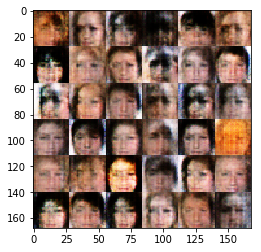

Epoch 1/1... Discriminator Loss: 1.0507... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 0.6457... Generator Loss: 1.8086
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 0.9523... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 0.6467... Generator Loss: 1.9113
Epoch 1/1... Discriminator Loss: 0.5639... Generator Loss: 3.4702
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 4.6993
Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 0.9551


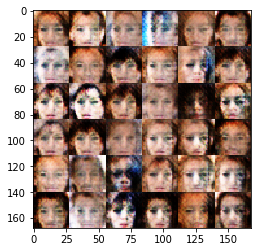

Epoch 1/1... Discriminator Loss: 0.6612... Generator Loss: 1.6811
Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.4332
Epoch 1/1... Discriminator Loss: 0.6761... Generator Loss: 1.6300
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.4608
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.0749
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.0403
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.6209
Epoch 1/1... Discriminator Loss: 0.6893... Generator Loss: 2.0552
Epoch 1/1... Discriminator Loss: 0.7641... Generator Loss: 2.7620
Epoch 1/1... Discriminator Loss: 0.6837... Generator Loss: 1.8855


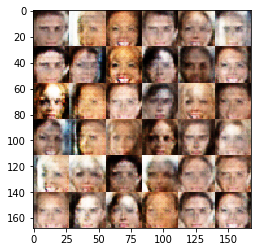

Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 2.0097
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.1519
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 0.5733... Generator Loss: 1.7631
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.5586... Generator Loss: 1.7812
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.9232
Epoch 1/1... Discriminator Loss: 1.7460... Generator Loss: 5.3681
Epoch 1/1... Discriminator Loss: 0.5864... Generator Loss: 1.9274


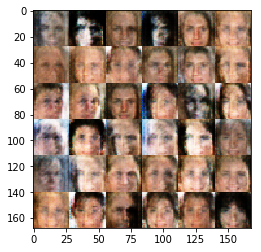

Epoch 1/1... Discriminator Loss: 0.5894... Generator Loss: 1.9826
Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.3453
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 3.8374
Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.2134
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.7243
Epoch 1/1... Discriminator Loss: 2.0939... Generator Loss: 5.6332
Epoch 1/1... Discriminator Loss: 0.9850... Generator Loss: 0.9073
Epoch 1/1... Discriminator Loss: 0.7534... Generator Loss: 1.3594
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.3089
Epoch 1/1... Discriminator Loss: 1.9119... Generator Loss: 0.3495


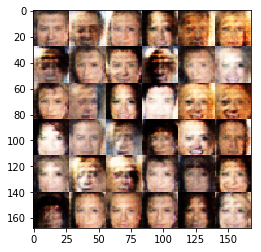

Epoch 1/1... Discriminator Loss: 0.7709... Generator Loss: 2.3252
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.9361
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.6703
Epoch 1/1... Discriminator Loss: 0.5783... Generator Loss: 1.8363
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.5028
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.2304
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 2.3183
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 1.4618
Epoch 1/1... Discriminator Loss: 0.5726... Generator Loss: 2.1186
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.7772


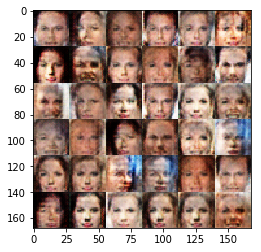

Epoch 1/1... Discriminator Loss: 0.7465... Generator Loss: 3.7660
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 0.7700... Generator Loss: 1.6120
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 4.1717
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 2.3442
Epoch 1/1... Discriminator Loss: 1.0560... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 0.6747... Generator Loss: 1.8934
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.4466


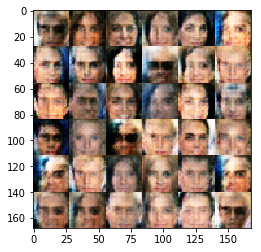

Epoch 1/1... Discriminator Loss: 0.7597... Generator Loss: 1.5334
Epoch 1/1... Discriminator Loss: 0.8254... Generator Loss: 1.6723
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.3814
Epoch 1/1... Discriminator Loss: 0.7393... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 0.6071... Generator Loss: 2.4195
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 1.2610
Epoch 1/1... Discriminator Loss: 0.6521... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.5704
Epoch 1/1... Discriminator Loss: 1.9058... Generator Loss: 0.3912
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.9574


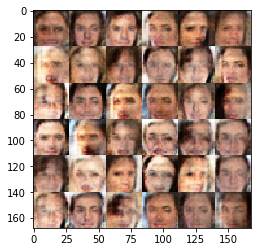

Epoch 1/1... Discriminator Loss: 0.7634... Generator Loss: 2.8625
Epoch 1/1... Discriminator Loss: 0.7434... Generator Loss: 2.8459
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.6981... Generator Loss: 1.8455
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.6799
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 0.9102... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.5581
Epoch 1/1... Discriminator Loss: 0.7883... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.9764


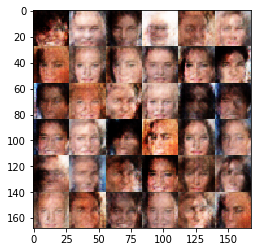

Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 0.9396
Epoch 1/1... Discriminator Loss: 2.3574... Generator Loss: 5.5844
Epoch 1/1... Discriminator Loss: 0.6061... Generator Loss: 2.6146
Epoch 1/1... Discriminator Loss: 0.5054... Generator Loss: 2.1959
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 2.7904
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 2.2668
Epoch 1/1... Discriminator Loss: 1.0243... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 1.3726


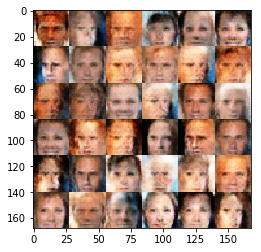

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 2.7449
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 0.6742... Generator Loss: 1.6422
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.4091
Epoch 1/1... Discriminator Loss: 0.8474... Generator Loss: 2.7174
Epoch 1/1... Discriminator Loss: 0.5793... Generator Loss: 1.9469
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 2.5548
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 0.8370


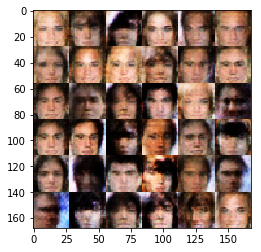

Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.3873
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.0839
Epoch 1/1... Discriminator Loss: 0.6585... Generator Loss: 1.6298
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 1.8517
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.2353
Epoch 1/1... Discriminator Loss: 0.6730... Generator Loss: 1.6211
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 1.6890
Epoch 1/1... Discriminator Loss: 2.0491... Generator Loss: 5.4439
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 2.8992


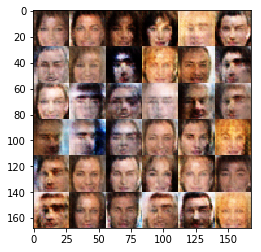

Epoch 1/1... Discriminator Loss: 0.6717... Generator Loss: 3.4958
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 1.8844
Epoch 1/1... Discriminator Loss: 1.6460... Generator Loss: 5.3548
Epoch 1/1... Discriminator Loss: 0.7163... Generator Loss: 1.5548
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 2.9023


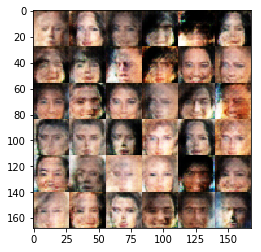

model trained


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.